In [2]:
import math 
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite
import networkx as nx
from ortools.linear_solver import pywraplp as OR
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import copy
import pickle
from bokeh import palettes
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import (GraphRenderer, Circle, MultiLine, StaticLayoutProvider,
                          HoverTool, TapTool, EdgesAndLinkedNodes, NodesAndLinkedEdges,
                          ColumnDataSource, LabelSet, NodesOnly)
output_notebook()

Loading BokehJS ...

## Data Input

In [3]:
trips_df = pd.read_csv('data/2013-09-01_trip_data_manhattan.csv').drop(columns='id')
nodes_df = pd.read_csv('data/nyc_nodes_manhattan.csv').drop(columns='Unnamed: 0')
arcs_df = pd.read_csv('data/nyc_links_manhattan.csv').drop(columns='Unnamed: 0')
# A dictionary with dropoff-pickup pairs as keys and travel times as values - generated from another notebook
with open('data/time_map.pkl', 'rb') as f:
    times = pickle.load(f)

In [21]:
trips_df['revenue'] = 2.50 + 1.56*trips_df.trip_distance + 0.50*trips_df.trip_time
trips_df.revenue = trips_df.revenue.apply(lambda x: round(x,2))

In [4]:
def compute_distance(lat1,lon1,lat2,lon2):
    
    R = 6371  # Radius of the earth in km
    return R * np.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2) * np.pi / 180

In [7]:
trips_df

,medallion,hack_license,start_node,end_node,start_time,trip_time,passenger_count,trip_distance,revenue
0,2013001161,2013017895,333,692,0,6,5,2.204796,8.94
1,2013002825,2013002822,1802,110,0,7,1,1.738087,8.71
2,2013003234,2013003230,1769,77,0,9,1,5.262542,15.21
3,2013011126,2013024686,526,2573,0,18,5,2.687598,15.69
4,2013011030,2013003058,148,2662,0,32,5,13.067841,38.89
...,...,...,...,...,...,...,...,...,...
131451,2013003493,2013003489,2644,1988,1440,3,1,0.643736,5.00
131452,2013000939,2013000936,366,1408,1440,8,3,1.770274,9.26
131453,2013000219,2013008844,1783,2714,1440,10,1,3.379614,12.77
131454,2013010721,2013025037,1575,1422,1440,13,1,7.402964,20.55


In [8]:
nodes_df

,name,lon,lat,x,y
0,0,-74.003837,40.710545,-8.238069e+06,4.969740e+06
1,1,-73.969571,40.749594,-8.234255e+06,4.975477e+06
2,2,-73.964442,40.753157,-8.233684e+06,4.976000e+06
3,3,-74.012328,40.713941,-8.239015e+06,4.970239e+06
4,4,-74.008254,40.736961,-8.238561e+06,4.973621e+06
...,...,...,...,...,...
3058,3058,-73.968561,40.801643,-8.234143e+06,4.983128e+06
3059,3059,-73.965705,40.800431,-8.233825e+06,4.982950e+06
3060,3060,-73.962876,40.799237,-8.233510e+06,4.982774e+06
3061,3061,-73.961474,40.798645,-8.233354e+06,4.982687e+06


In [5]:
# filter trips by time window of interest
start_time = 0
end_time = 1440
trips = trips_df.copy()
trips = trips[(trips.start_time >= start_time) & 
              (trips.start_time + trips.trip_time <= end_time)].copy()
trips.start_time = trips.start_time - start_time

In [6]:
trips

,medallion,hack_license,start_node,end_node,start_time,trip_time,passenger_count,trip_distance
0,2013001161,2013017895,333,692,0,6,5,2.204796
1,2013002825,2013002822,1802,110,0,7,1,1.738087
2,2013003234,2013003230,1769,77,0,9,1,5.262542
3,2013011126,2013024686,526,2573,0,18,5,2.687598
4,2013011030,2013003058,148,2662,0,32,5,13.067841
...,...,...,...,...,...,...,...,...
131194,2013012429,2013009682,65,2344,1437,3,1,1.770274
131197,2013007450,2013007446,1488,409,1437,3,1,1.448406
131206,2013004329,2013004326,1798,751,1437,2,1,1.287472
131233,2013008371,2013024554,2678,110,1438,2,2,0.804670


In [7]:
# Intialize nodes and edges
DO_nodes = list()
PU_nodes = list()
edges = list()
# Initialize a dict that maps a PU node to a DO node
PUtoDO = dict()

In [8]:
# Specify nodes - each node is a tuple of (location_id, time, trip_id, "DO"/"PU")

for index, row in trips.iterrows():
    s = row['start_node']
    t = row['end_node']
    s_t = row['start_time']
    t_t = s_t + row['trip_time']
    DO_node = (int(t), t_t, index, 'DO')
    PU_node = (int(s), s_t, index, 'PU')
    DO_nodes.append(DO_node)
    PU_nodes.append(PU_node)
    PUtoDO[PU_node] = DO_node

In [9]:
# Sort the nodes by time
DO_nodes = sorted(DO_nodes, key = lambda x: x[1])
PU_nodes = sorted(PU_nodes, key = lambda x: x[1])

In [90]:
# Specify edges
max_waiting_time = 5

for DO_node in DO_nodes:
    for PU_node in PU_nodes:
        if PU_node[1] > DO_node[1] + max_waiting_time:
            break
        else:
            if PU_node[1] >= DO_node[1]:
                time = times[(DO_node[0], PU_node[0])]
                if ((PU_node[1] - DO_node[1]) - max_waiting_time  <= time) & (time <= (PU_node[1] - DO_node[1])):
                    edges.append((DO_node, PU_node))

## Bipartite Matching

In [91]:
# load the model
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(DO_nodes, bipartite=0)
B.add_nodes_from(PU_nodes, bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from(edges)

In [92]:
top_nodes = {n for n, d in B.nodes(data = True) if d["bipartite"] == 0}

In [93]:
match = nx.bipartite.maximum_matching(B, DO_nodes)

In [94]:
print('max cardinality:', len(match) / 2)

max cardinality: 148.0


In [95]:
# calculate number of unmatched nodes (minimum number of taxis needed)
print('min number of taxis needed: ', len(DO_nodes) - len(match)/2)

min number of taxis needed:  644.0


## IP formulation

In [96]:
# A dictionary that stores the list of edges adjacent to node
incident = dict()
for v in (DO_nodes + PU_nodes):
    incident[v] = [edge for edge in edges if v in edge]

In [97]:
solver = OR.Solver.CreateSolver('SCIP')
# decision variables
x = {}  
for e in edges:
    x[e] = solver.IntVar(0, 1, ('(%s)' % str(e)))

solver.Maximize(sum(x[e] for e in edges))

for v in (DO_nodes + PU_nodes):
    if v in incident.keys():
        solver.Add(sum(x[e] for e in incident[v]) <= 1)

In [98]:
solver.Solve()
print('Solution:')
print('Objective value =', solver.Objective().Value())
for var in solver.variables():
    if var.solution_value() == 1:
        print(var.name())

Solution:
Objective value = 148.0
(((1202, 2.0, 81081, 'DO'), (1202, 2.0, 81296, 'PU')))
(((526, 2.0, 81132, 'DO'), (526, 2.0, 81385, 'PU')))
(((895, 2.0, 81142, 'DO'), (2768, 4.0, 81557, 'PU')))
(((63, 2.0, 81233, 'DO'), (546, 6.0, 81752, 'PU')))
(((1219, 3.0, 81051, 'DO'), (2852, 6.0, 81731, 'PU')))
(((692, 3.0, 81077, 'DO'), (1575, 8.0, 81998, 'PU')))
(((1426, 3.0, 81079, 'DO'), (2442, 4.0, 81583, 'PU')))
(((581, 3.0, 81090, 'DO'), (889, 8.0, 81954, 'PU')))
(((2555, 3.0, 81111, 'DO'), (1476, 5.0, 81660, 'PU')))
(((901, 3.0, 81127, 'DO'), (2778, 6.0, 81726, 'PU')))
(((10, 3.0, 81128, 'DO'), (1798, 6.0, 81729, 'PU')))
(((316, 3.0, 81139, 'DO'), (491, 5.0, 81629, 'PU')))
(((2516, 3.0, 81150, 'DO'), (2182, 5.0, 81667, 'PU')))
(((1796, 3.0, 81158, 'DO'), (899, 8.0, 81972, 'PU')))
(((238, 3.0, 81163, 'DO'), (1476, 4.0, 81575, 'PU')))
(((1283, 3.0, 81188, 'DO'), (1220, 4.0, 81540, 'PU')))
(((1314, 3.0, 81247, 'DO'), (1312, 8.0, 82007, 'PU')))
(((1959, 3.0, 81277, 'DO'), (540, 8.0, 82028, '

In [99]:
print('Number of constraints =', solver.NumConstraints())

Number of constraints = 1584


## max flow formulation

In [100]:
G = nx.DiGraph()
G.add_nodes_from(PU_nodes + DO_nodes + ['s'] + ['t'])
for edge in edges:
    G.add_edge(edge[0], edge[1], capacity = 1)
for DO_node in DO_nodes:
    G.add_edge('s', DO_node, capacity = 1)
for PU_node in PU_nodes:
    G.add_edge(PU_node, 't', capacity = 1)

In [101]:
flow_value, flow_dict = nx.maximum_flow(G, "s", "t")

In [102]:
print('max flow value: ', flow_value)

max flow value:  148


In [103]:
# Try another alogrithm to solve max flow
from networkx.algorithms.flow import shortest_augmenting_path
nx.maximum_flow(G, "s", "t", flow_func=shortest_augmenting_path)[0]

148

## Turn this into a function

In [214]:
def min_taxi(start_time, end_time, trips_df, max_waiting_time):
    # filter trips by time window of interest
    trips = trips_df.copy()
    trips = trips[(trips.start_time >= start_time) & 
                  (trips.start_time + trips.trip_time <= end_time)].copy()
    trips.start_time = trips.start_time - start_time

    # create a dictionary to map the location pairs to trip time
    loc_time = dict()
    for index, row in arcs_df.iterrows():
        i = row['start']
        j = row['end']
        delay = row['trip_time']
        loc_time[(i, j)] = delay
    # Intialize nodes and edges
    DO_nodes = list()
    PU_nodes = list()
    edges = list()
    # Initialize a dict that maps a PU node to a DO node
    PUtoDO = dict()
    
    # Specify nodes - each node is a tuple of (location_id, time, trip_id, "DO"/"PU")
    for index, row in trips.iterrows():
        s = row['start_node']
        t = row['end_node']
        s_t = row['start_time']
        t_t = s_t + row['trip_time']
        DO_node = (int(t), t_t, index, 'DO')
        PU_node = (int(s), s_t, index, 'PU')
        DO_nodes.append(DO_node)
        PU_nodes.append(PU_node)
        PUtoDO[PU_node] = DO_node
    DO_nodes = sorted(DO_nodes, key = lambda x: x[1])
    PU_nodes = sorted(PU_nodes, key = lambda x: x[1])
    
    # Specify edges
    for DO_node in DO_nodes:
        for PU_node in PU_nodes:
            if PU_node[1] > DO_node[1] + max_waiting_time:
                break
            else:
                if PU_node[1] >= DO_node[1]:
                    time = times[(DO_node[0], PU_node[0])]
                    if ((PU_node[1] - DO_node[1]) - max_waiting_time <= time) & (time <= (PU_node[1] - DO_node[1])):
                        edges.append((DO_node, PU_node))
    
    # load the model
    B = nx.Graph()
    # Add nodes with the node attribute "bipartite"
    B.add_nodes_from(DO_nodes, bipartite=0)
    B.add_nodes_from(PU_nodes, bipartite=1)
    # Add edges only between nodes of opposite node sets
    B.add_edges_from(edges)
    
    top_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
    match = nx.bipartite.maximum_matching(B, top_nodes)
    print('max cardinality: ', len(match) / 2)
    min_num_taxi = (len(DO_nodes) - len(match)/2)

    return match, min_num_taxi, trips, B

In [215]:
import time
start_time = time.time()
match, num_taxi, trips, B = min_taxi(1020, 1035, trips_df, 5)
print("--- %s seconds ---" % (time.time() - start_time))

max cardinality:  148.0
--- 0.8316848278045654 seconds ---


In [42]:
# start_time = time.time()
# match, num_taxi,trips,PU_nodes, DO_nodes = min_taxi(1020, 1140, trips_df, 5)
# print("--- %s seconds ---" % (time.time() - start_time))

In [216]:
# try running a day
start_time = time.time()
match, num_taxi, trips, B = min_taxi(0, 1440, trips_df, 10)
print("--- %s seconds ---" % (time.time() - start_time))

max cardinality:  123027.0
--- 10476.717824697495 seconds ---


In [217]:
# Save the results
with open('data/match.pkl', 'wb') as f:
    pickle.dump(match, f)
# Dump graph
with open("data/bipartite.pkl", 'wb') as f:
    pickle.dump(B, f)


In [10]:
# Load graph
with open("data/bipartite.pkl", 'rb') as f:  # notice the r instead of w
    B = pickle.load(f)
        
with open('data/match.pkl', 'rb') as f:
    match = pickle.load(f)

## Visualize the taxi paths

In [11]:
DO_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
PU_nodes = set(B) - DO_nodes

In [12]:
unmatch_PU = list(set(PU_nodes) - set(match.keys()))
unmatch_DO = list(set(DO_nodes) - set(match.keys()))

In [13]:
len(unmatch_DO)

7475

In [14]:
# track the paths of the taxis
opt_paths = []
for PU_node in unmatch_PU:
    path = []
    # Find the drop-off node corresponding to the first unmatched pick-up node
    next_node = PUtoDO[PU_node]
    path.append((PU_node, next_node, True))
    while next_node in match.keys():
        if next_node[-1] == 'PU':
            cur_node = copy.deepcopy(next_node)
            next_node = PUtoDO[cur_node]
            path.append((cur_node, next_node, True))
        else:
            cur_node = copy.deepcopy(next_node)
            next_node = match[cur_node]
            path.append((cur_node, next_node, False))
    opt_paths.append(path)

In [15]:
# Construct the street network
G = nx.Graph()
for l in range(len(nodes_df)):
    G.add_node(l)
for index, row in arcs_df.iterrows():
    i = row['start']
    j = row['end']
    G.add_edge(i, j, weight = row['trip_time'])

In [16]:
def plot_taxi_route(paths, title = 'Taxi Routes'):
    """Plot the path of every taxi in the given list on the Manhattan grid."""
    
    # parallel lists for every arc
    start = []  # start node
    end = []  # end node
    color = []  # color code by taxi
    alpha = []  # opacity lower on trip arcs

    # parallel lists for initial location nodes
    start_nodes = []
    start_colors = []

    colors = palettes.Category10[10]
    c = 0

    for path in paths:

        # add start node information for this taxi
        start_nodes.append(path[0][0][0])
        start_colors.append(colors[c])

        for comp in path:
            try:
                shortest_path = nx.shortest_path(G, source= comp[0][0], target= comp[1][0], weight = 'weight')
                for i in range(0, len(shortest_path) - 1):
                    start.append(shortest_path[i])
                    end.append(shortest_path[i + 1])
                    alpha.append({True : 1, False : 0.3}[comp[2]])
                    color.append(colors[c])

            except nx.NetworkXNoPath:
                start.append(comp[0][0])
                end.append(comp[1][0])
                alpha.append({True : 1, False : 0.3}[comp[2]])
                color.append(colors[c])

        c = c + 1 if c < len(colors)-1 else 0

    # parallel lists for nodes
    nodes = nodes_df.loc[list(set(start + end))]
    node_ids = nodes.name.values.tolist()
    x = nodes.x.values.tolist()
    y = nodes.y.values.tolist()

    # get plot boundaries
    min_x, max_x = min(nodes.x)-1000, max(nodes.x)+1000
    min_y, max_y = min(nodes.y)-1000, max(nodes.y)+1000

    plot = figure(x_range=(min_x, max_x), y_range=(min_y, max_y),
                  x_axis_type="mercator", y_axis_type="mercator",
                  title= title, plot_width=600, plot_height=470)
    plot.add_tile(get_provider(Vendors.CARTODBPOSITRON_RETINA))

    graph = GraphRenderer()

    # define initial location nodes
    graph.node_renderer.data_source.add(start_nodes, 'index')
    graph.node_renderer.data_source.add(start_colors, 'start_colors')
    graph.node_renderer.glyph = Circle(size=7,line_width=0,fill_alpha=1, fill_color='start_colors')

     # define network edges
    graph.edge_renderer.data_source.data = dict(start=list(start),
                                                end=list(end),
                                                color=list(color),
                                                alpha=list(alpha))
    graph.edge_renderer.glyph = MultiLine(line_color='color', line_alpha='alpha',
                                         line_width=3,line_cap='round')

    # set node locations
    graph_layout = dict(zip(node_ids, zip(x, y)))
    graph.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)

    plot.renderers.append(graph)
    show(plot)

In [30]:
plot_taxi_route(opt_paths[:3])

In [31]:
# Select all the routes with more than 1 trip
opt_paths2 = []
for path in opt_paths:
    if len(path) > 1:
        opt_paths2.append(path)

In [32]:
plot_taxi_route(opt_paths2[:5], 'Optimal Sample Taxi Routes')

### Determine the original paths of the taxis

In [33]:
# Count the original number of taxis
taxi_list = pd.unique(trips.medallion)
print('original number of taxis:',len(taxi_list))

original number of taxis: 11568


In [24]:
og_paths = []
for taxi_id in taxi_list:
    taxi_trips = trips[trips.medallion == taxi_id]
    path = []
    # Append the first trip to the path
    first_row = taxi_trips.iloc[0]
    PU_node = (first_row['start_node'], first_row['start_time'], index, 'PU')
    DO_node = (first_row['end_node'], first_row['start_time'] + first_row['trip_time'], index, 'DO')
    path.append((PU_node, DO_node, True))
    prev_DO = copy.deepcopy(DO_node)
    # Iterate through the rest of the trips
    for index, row in taxi_trips.iloc[1:].iterrows():
        PU_node = (row['start_node'], row['start_time'], index, 'PU')
        DO_node = (row['end_node'], row['start_time'] + row['trip_time'], index, 'DO')
        path.append((prev_DO, PU_node, False))
        path.append((PU_node, DO_node, True))
        prev_DO = copy.deepcopy(DO_node)
    og_paths.append(path)

In [35]:
# Select all the routes with more than 1 trip
og_paths2 = []
for path in og_paths:
    if len(path) > 1:
        og_paths2.append(path)

In [36]:
plot_taxi_route(og_paths2[:5], 'Original Sample Taxi Routes')

In [49]:
opt_paths

[[((1776, 7.0, 1158, 'PU'), (1953, 21.0, 1158, 'DO'), True),
  ((1953, 21.0, 1158, 'DO'), (1955, 27.0, 4313, 'PU'), False),
  ((1955, 27.0, 4313, 'PU'), (1795, 33.0, 4313, 'DO'), True),
  ((1795, 33.0, 4313, 'DO'), (1795, 35.0, 5499, 'PU'), False),
  ((1795, 35.0, 5499, 'PU'), (643, 42.0, 5499, 'DO'), True),
  ((643, 42.0, 5499, 'DO'), (927, 50.0, 7773, 'PU'), False),
  ((927, 50.0, 7773, 'PU'), (1519, 58.0, 7773, 'DO'), True),
  ((1519, 58.0, 7773, 'DO'), (2515, 59.0, 8932, 'PU'), False),
  ((2515, 59.0, 8932, 'PU'), (1497, 69.0, 8932, 'DO'), True),
  ((1497, 69.0, 8932, 'DO'), (2676, 73.0, 10708, 'PU'), False),
  ((2676, 73.0, 10708, 'PU'), (2858, 83.0, 10708, 'DO'), True),
  ((2858, 83.0, 10708, 'DO'), (167, 89.0, 12611, 'PU'), False),
  ((167, 89.0, 12611, 'PU'), (1110, 91.0, 12611, 'DO'), True),
  ((1110, 91.0, 12611, 'DO'), (938, 100.0, 13882, 'PU'), False),
  ((938, 100.0, 13882, 'PU'), (2717, 116.0, 13882, 'DO'), True),
  ((2717, 116.0, 13882, 'DO'), (724, 126.0, 16412, 'PU'), 

### Calculate the third solution - cutting paths that last for more than some threshold time

In [43]:
np.mean(og_total_trip_time)

16.069902604887048

### Compare metrics of the optimal taxi paths and the original taxi paths

In [17]:
# Number of Taxis
taxi_list = pd.unique(trips.medallion)
print('Original number of taxis:', len(taxi_list))
print('Optimal number of taxis:', len(unmatch_DO))

Original number of taxis: 11568
Optimal number of taxis: 7475


In [22]:
def get_taxi_stats(taxi_paths):
    """Get statistics of every taxi."""
    paths_stats =[]
    for paths in taxi_paths:
        path_stats = []
        for path in paths:
            tail = path[1]
            head = path[0]
            time = tail[1] - head[1]
            moving = (tail[0] != head[0])
            not_empty = path[2]
            trip_id = head[2]
            path_stats.append((time, moving, not_empty, trip_id))
        paths_stats.append(path_stats)

    taxi_stats = []
    for path in paths_stats:
        unzipped = list(zip(*path))
        total_time = sum(np.array(unzipped[0]))
        moving_time = sum(np.array(unzipped[0])[list(unzipped[1])])
        trip_time = sum(np.array(unzipped[0])[list(unzipped[2])])
        trip_IDs = list(np.array(unzipped[3])[list(unzipped[2])])
        num_trips = len(trip_IDs)
        trips = trips_df.loc[trip_IDs]
        total_trip_distance = None if any(trips['trip_distance'].isna()) else sum(trips['trip_distance'])
        total_passengers = None if any(trips['passenger_count'].isna()) else sum(trips['passenger_count'])
        revenue = None if any(trips['revenue'].isna()) else sum(trips['revenue'])
        taxi_stats.append({'moving_pct' : moving_time / total_time,
                           'on_trip_pct' : trip_time / total_time,
                           'num_trips' : num_trips,
                           'total_trip_distance' : total_trip_distance,
                           'total_passengers' : total_passengers,
                           'revenue' : revenue,
                          'total_time': total_time / 60,
                          'total_empty': (total_time - trip_time)/60})
    return taxi_stats

In [25]:
opt_stats = get_taxi_stats(opt_paths)
opt_total_num_trips = [stat['num_trips'] for stat in opt_stats]
opt_empty_time = [stat['total_empty'] for stat in opt_stats]
opt_total_time = [stat['total_time'] for stat in opt_stats]
opt_on_trip = [stat['on_trip_pct'] for stat in opt_stats]


og_stats = get_taxi_stats(og_paths)
og_total_num_trips = [stat['num_trips'] for stat in og_stats]
og_empty_time = [stat['total_empty'] for stat in og_stats]
og_total_time = [stat['total_time'] for stat in og_stats]
og_on_trip = [stat['on_trip_pct'] for stat in og_stats]


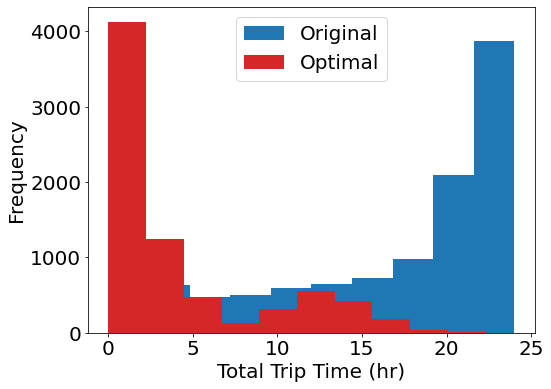

In [26]:
# Total Trip Time
plt.rcParams.update({'font.size': 20})
fig, ax= plt.subplots(1,1, figsize=(8, 6))
plt.hist(og_total_time, label = 'Original')
plt.hist(opt_total_time, color ='tab:red', label = 'Optimal')
ax.set_xlabel('Total Trip Time (hr)')
ax.set_ylabel('Frequency')
ax.legend(loc="best", prop={'size': 20});
fig.savefig('visuals/total_trip_time.png', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)

In [27]:
print(np.mean(og_total_time))
print(np.mean(opt_total_time))

16.069902604887048
4.161567447045708


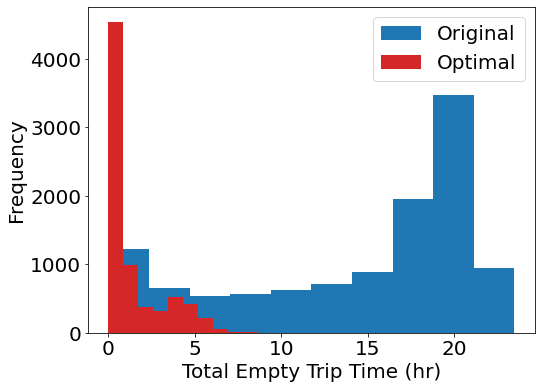

In [79]:
# Total Empty Trip Time
plt.rcParams.update({'font.size': 20})
fig, ax= plt.subplots(1,1, figsize=(8, 6))
plt.hist(og_empty_time, label = 'Original')
plt.hist(opt_empty_time, color ='tab:red', label = 'Optimal')
ax.set_xlabel('Total Empty Trip Time (hr)')
ax.set_ylabel('Frequency')
ax.legend(loc="best", prop={'size': 20});
fig.savefig('visuals/empty_trip_time.png', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)

In [28]:
print(np.mean(og_empty_time))
print(np.mean(opt_empty_time))

14.26078550023052
1.3618528428093644


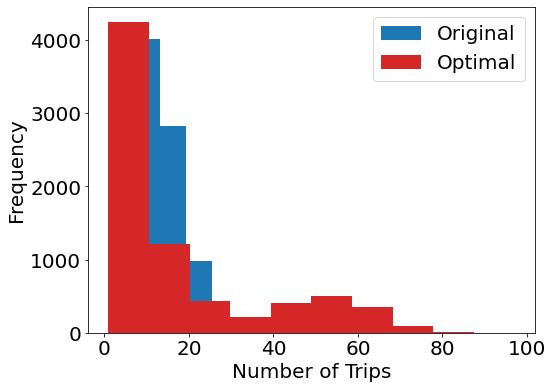

In [80]:
# Number of Trips
plt.rcParams.update({'font.size': 20})
fig, ax= plt.subplots(1,1, figsize=(8, 6))
plt.hist(og_total_num_trips, label = 'Original')
plt.hist(opt_total_num_trips, color ='tab:red', label = 'Optimal')
ax.set_xlabel('Number of Trips')
ax.set_ylabel('Frequency')
ax.legend(loc="best", prop={'size': 20});
fig.savefig('visuals/num_trip.png', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)

In [29]:
print(np.mean(og_total_num_trips))
print(np.mean(opt_total_num_trips))

11.281293222683264
17.45846153846154


array([  6.0475162 ,   8.96399706,  11.97263398, ..., 100.        ,
       100.        , 100.        ])

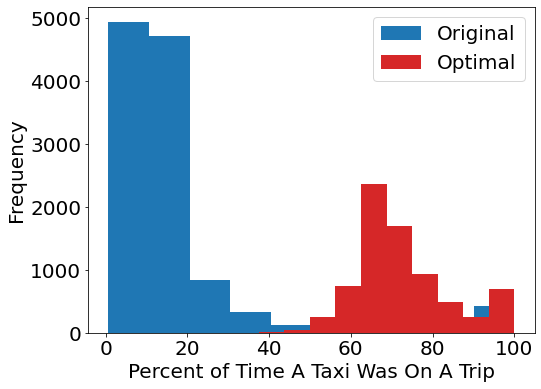

In [36]:
# On-Trip Percentage
plt.rcParams.update({'font.size': 20})
fig, ax= plt.subplots(1,1, figsize=(8, 6))
plt.hist(np.array(og_on_trip) * 100 , label = 'Original')
plt.hist(np.array(opt_on_trip) * 100, color ='tab:red', label = 'Optimal')
ax.set_xlabel('Percent of Time A Taxi Was On A Trip')
ax.set_ylabel('Frequency')
ax.legend(loc="best", prop={'size': 20});
fig.savefig('visuals/on_trip_pct.png', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)

In [30]:
print(np.mean(og_on_trip))
print(np.mean(opt_on_trip))

0.1713298765622003
0.726199376275021


In [145]:
def agg_stats(taxi_stats):
    B_max = len(taxi_stats)
    avg_moving_pct = sum([stat['moving_pct'] for stat in taxi_stats]) / B_max
    avg_trip_pct = sum([stat['on_trip_pct'] for stat in taxi_stats]) / B_max
    total_num_trips = sum([stat['num_trips'] for stat in taxi_stats])

    trip_distance_list = [stat['total_trip_distance'] for stat in taxi_stats]
    passengers_list = [stat['total_passengers'] for stat in taxi_stats]
    revenue_list = [stat['revenue'] for stat in taxi_stats]

    avg_total_trip_distance = sum(trip_distance_list) / B_max if None not in trip_distance_list else None
    total_passengers = sum(passengers_list) if None not in passengers_list else None
    avg_revenue = sum(revenue_list) / B_max if None not in revenue_list else None
    total_revenue = sum(revenue_list) if None not in revenue_list else None
    
    print('Summary Statistics')
    print('Avg. Moving Pct.: %.2f' % (avg_moving_pct))
    print('Avg. On Trip Pct.: %.2f' % (avg_trip_pct))
    if not avg_total_trip_distance is None:
        print('Avg. Total Distance of Trips: %.2f' % (avg_total_trip_distance))
    if not avg_revenue is None:
        print('Avg. Revenue: %.2f' % (avg_revenue))
    print('Total Trips: %.2f' % (total_num_trips))
    print('Total Taxis: %.2f' % (B_max))
    if not total_passengers is None:
        print('Total Passengers: %.2f' % (total_passengers))
    if not total_revenue is None:
        print('Total Revenue: %.2f' % (total_revenue))

In [146]:
opt_taxi_stats = get_taxi_stats(opt_paths)
agg_stats(opt_taxi_stats)

Summary Statistics
Avg. Moving Pct.: 0.99
Avg. On Trip Pct.: 0.73
Avg. Total Distance of Trips: 60.38
Avg. Revenue: 221.84
Total Trips: 130502.00
Total Taxis: 7475.00
Total Passengers: 238749.00
Total Revenue: 1658229.48


In [147]:
og_taxi_stats = get_taxi_stats(og_paths)
agg_stats(og_taxi_stats)

Summary Statistics
Avg. Moving Pct.: 1.00
Avg. On Trip Pct.: 0.17
Avg. Total Distance of Trips: 38.91
Avg. Revenue: 143.33
Total Trips: 130502.00
Total Taxis: 11568.00
Total Passengers: 238764.00
Total Revenue: 1658077.63


In [148]:
def plot_stats(taxi_stats):
    """Plot statistics using matplotlib."""        
    fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(20,10))

    def plot_histogram(stat, title, x_label, i, j):
        x = [i[stat] for i in taxi_stats]
        if None in x:
            return
        unique_vals = len(set(x))
        if unique_vals < 5:
            bins = unique_vals
        else:
            bins = int(max(5,min(20,unique_vals/2)))
        axs[i,j].hist(x, bins)
        axs[i,j].set_xlabel(x_label)
        axs[i,j].set_ylabel('Frequency')
        axs[i,j].set_title(title)

    plot_histogram(stat='moving_pct',
                   title='Histogram of Moving Percentage',
                   x_label='Percent of time a taxi was moving', i=0, j=0)

    plot_histogram(stat='on_trip_pct',
                   title='Histogram of On Trip Percentage',
                   x_label='Percent of time a taxi was on a trip', i=0, j=1)

    plot_histogram(stat='num_trips',
                   title='Histogram of Trips Accommodated',
                   x_label='Number of trips given', i=0, j=2)

    plot_histogram(stat='total_trip_distance',
                   title='Histogram of Trip Distance Travelled',
                   x_label='Total Trip Distance Travelled (km)', i=1, j=0)

    plot_histogram(stat='total_passengers',
                   title='Histogram of Passenger Count',
                   x_label='Number of Passengers', i=1, j=1)

    plot_histogram(stat='revenue',
                   title='Histogram of Revenue',
                   x_label='Revenue ($)', i=1, j=2)

    plt.show(fig)    

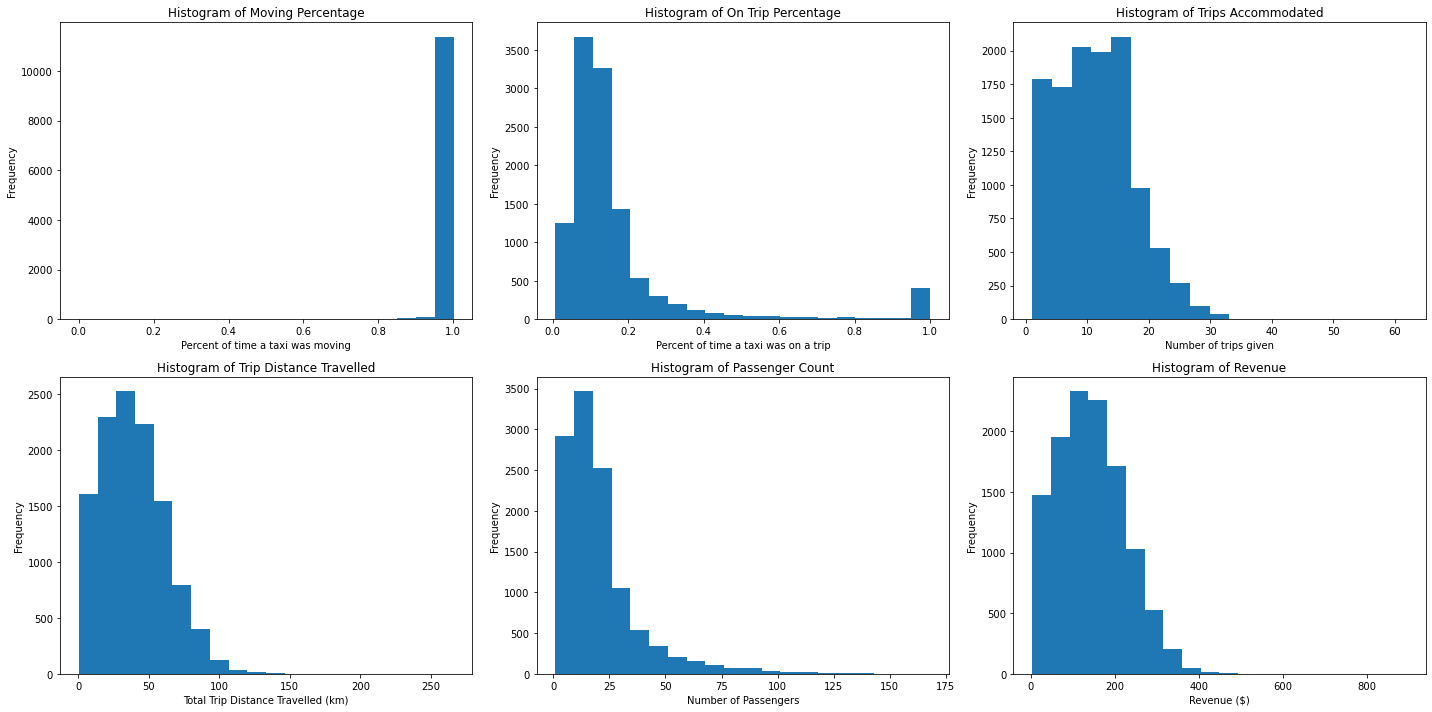

In [149]:
plot_stats(og_taxi_stats)

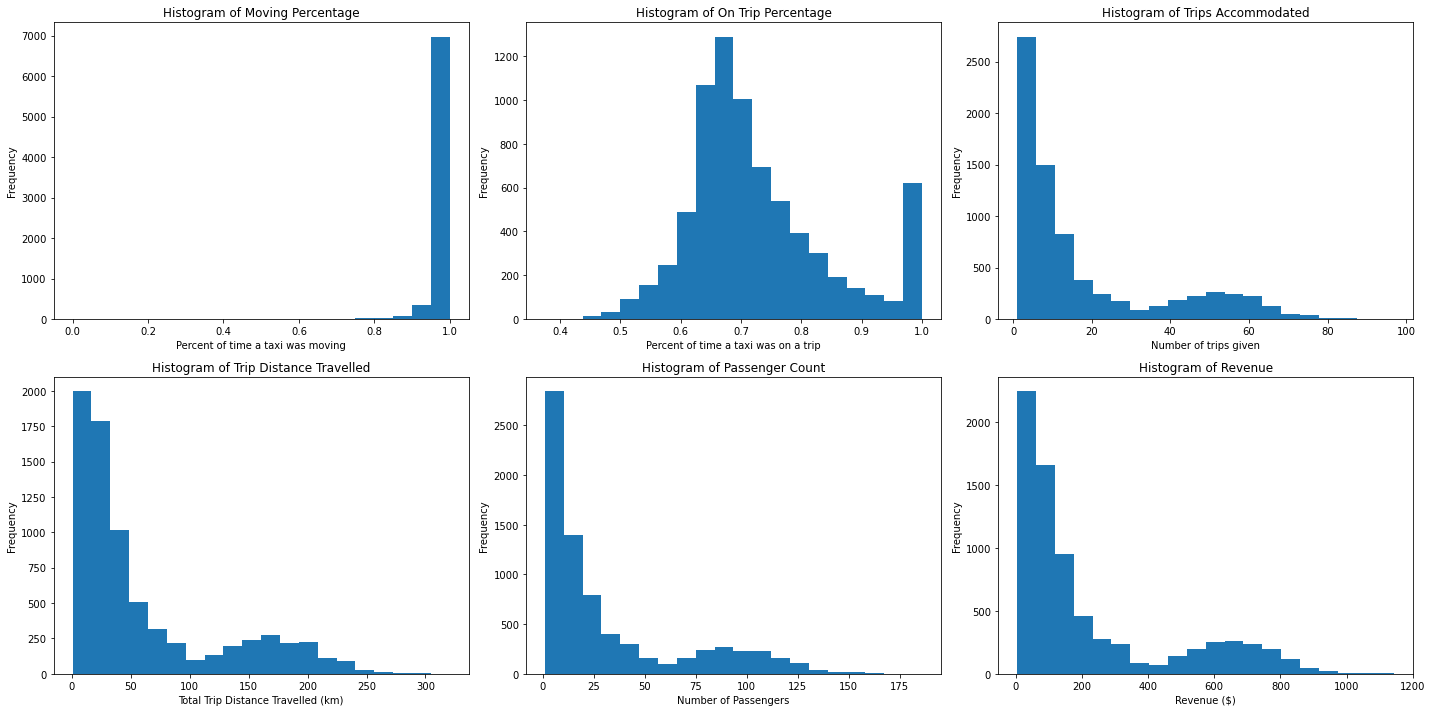

In [150]:
plot_stats(opt_taxi_stats)

In [83]:
# Distribution of taxis over one day
day_data = dict()
for time in np.arange(0, 1441):
    time_data = list()
    # Original total number of taxis
    total_count = 0
    for i in og_paths:
        start_time = i[0][0][1]
        end_time = i[-1][1][1]
        if start_time <= time and end_time >= time:
            total_count += 1
    # Minimum number of taxis required
    min_fleet = 0
    with_pass = 0
    do2pu = 0
    wait = 0
    for i in opt_paths:
        start_time = i[0][0][1]
        end_time = i[-1][1][1]
        if start_time <= time and end_time >= time:
            min_fleet += 1
            for comp in i:
                if comp[0][1] <= time and comp[1][1] >= time:
                    if comp[2]:
                        with_pass += 1
                    else: 
                        start_wait_time = comp[0][1] + times[(comp[0][0], comp[1][0])]
                        if time < start_wait_time:
                            do2pu += 1
                        else:
                            wait += 1
                    break
    time_data.extend((total_count, min_fleet, with_pass, do2pu, wait))
    day_data[time] = time_data

In [84]:
day_data

{0: [124, 124, 124, 0, 0],
 1: [287, 287, 287, 0, 0],
 2: [449, 448, 447, 1, 0],
 3: [610, 608, 604, 1, 3],
 4: [775, 766, 757, 4, 5],
 5: [948, 925, 903, 10, 12],
 6: [1112, 1068, 1036, 9, 23],
 7: [1267, 1190, 1142, 14, 34],
 8: [1414, 1306, 1235, 24, 47],
 9: [1561, 1412, 1313, 37, 62],
 10: [1695, 1505, 1385, 62, 58],
 11: [1819, 1585, 1420, 75, 90],
 12: [1945, 1651, 1444, 92, 115],
 13: [2074, 1725, 1491, 107, 127],
 14: [2184, 1773, 1502, 124, 147],
 15: [2310, 1814, 1509, 146, 159],
 16: [2408, 1844, 1527, 152, 165],
 17: [2516, 1883, 1542, 163, 178],
 18: [2610, 1907, 1550, 181, 176],
 19: [2712, 1934, 1556, 202, 176],
 20: [2813, 1963, 1568, 196, 199],
 21: [2901, 1981, 1551, 223, 207],
 22: [2990, 1999, 1572, 230, 197],
 23: [3084, 2021, 1573, 247, 201],
 24: [3163, 2033, 1581, 261, 191],
 25: [3263, 2049, 1563, 275, 211],
 26: [3351, 2055, 1567, 283, 205],
 27: [3453, 2061, 1536, 297, 228],
 28: [3545, 2068, 1564, 272, 232],
 29: [3631, 2084, 1590, 304, 190],
 30: [3705, 20

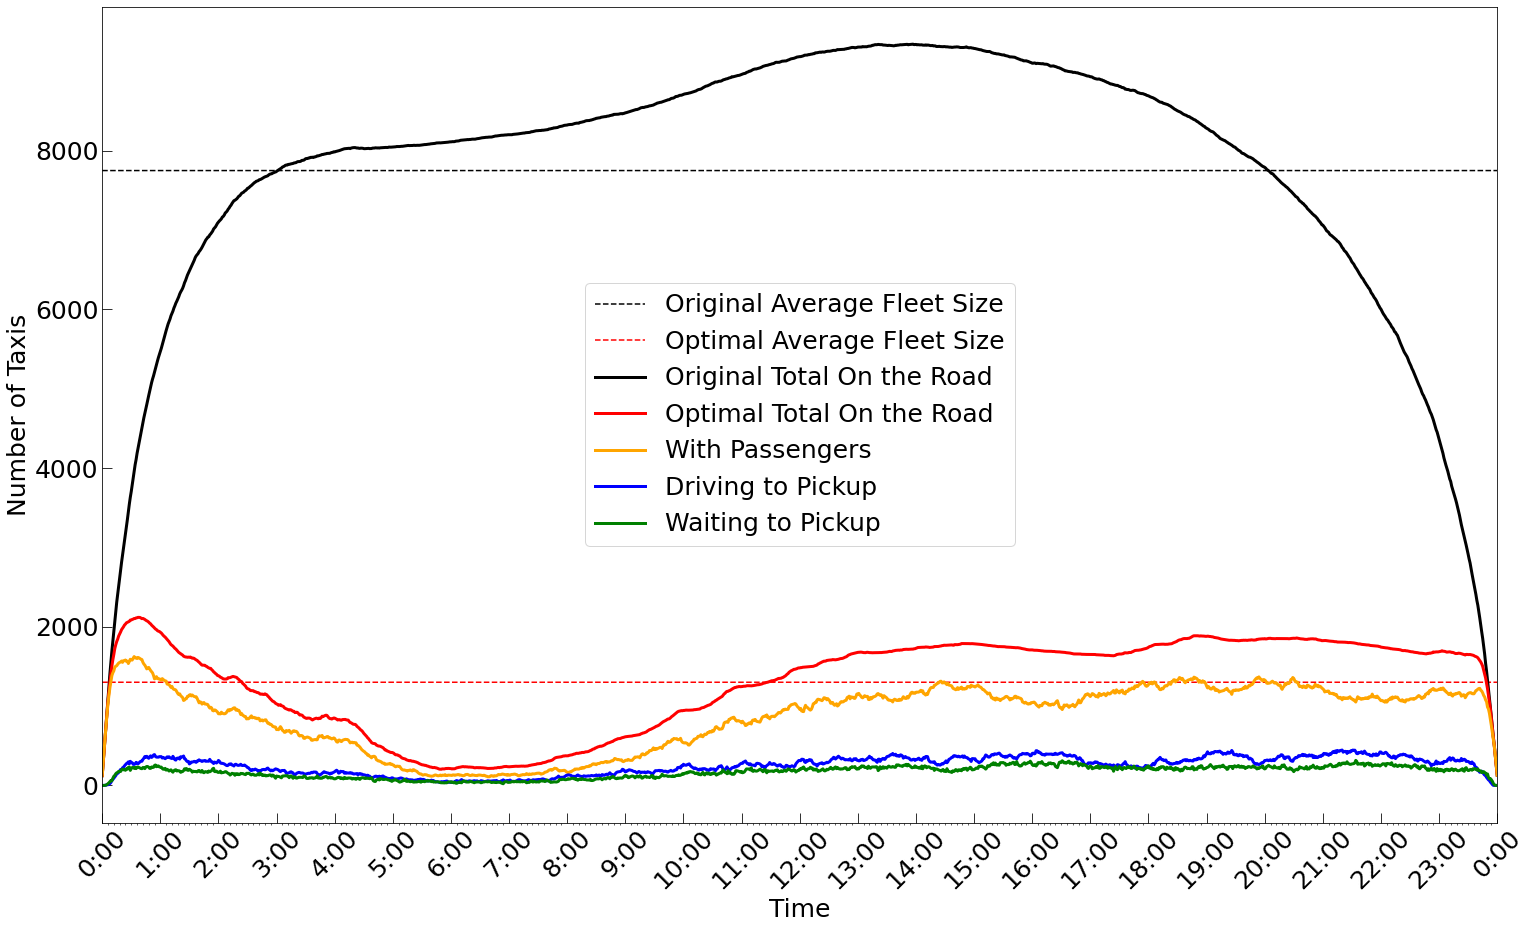

In [102]:
# Taxi distribution over a day
plt.rcParams.update({'font.size': 25})
fig, ax= plt.subplots(1,1, figsize=(25, 15))
unzipped = list(zip(*day_data.values()))
og_avg = np.mean(unzipped[0]) 
opt_avg = np.mean(unzipped[1])
plt.plot(day_data.keys(), [og_avg] *1441, 'black', linestyle='dashed', label = 'Original Average Fleet Size')
plt.plot(day_data.keys(), [opt_avg] * 1441, 'red', linestyle='dashed', label = 'Optimal Average Fleet Size')
c = ['black', 'red', 'orange', 'blue', 'green']
legends = ['Original Total On the Road', 'Optimal Total On the Road', 'With Passengers', 'Driving to Pickup', 'Waiting to Pickup']
i = 0
for data in unzipped:
    plt.plot(day_data.keys(), data, c[i], label = legends[i], linewidth= 3)
    i = i + 1

ax.xaxis.set_minor_locator(MultipleLocator(6))
ax.set_xlim([0, 1440])
ax.set_xticks(np.arange(0, 1450, 60))
ax.set_xticklabels(['%s:00'%str(i) for i in (list(np.arange(0, 24)) + [0])]);
ax.tick_params(axis="x",direction="in", which ='major', size= 10, rotation = 45)
ax.tick_params(axis="y",direction="in", which ='major', size= 10)

ax.legend(loc="best", prop={'size': 25})
ax.set_xlabel('Time')
ax.set_ylabel('Number of Taxis');
fig.savefig('visuals/taxi_time_dist.png', dpi = 1000, bbox_inches = 'tight', pad_inches = 0)

In [90]:
print('original number of circulating taxis', round(np.mean(unzipped[0])))
print('optimal number of circulating taxis', round(np.mean(unzipped[1])))

original number of circulating taxis 7748
optimal number of circulating taxis 1300


In [55]:
for edge in B.edges:
    if 81954 in edge[0]:
        print(edge)

((752, 1030.0, 81954, 'DO'), (751, 1033.0, 82629, 'PU'))
((752, 1030.0, 81954, 'DO'), (2765, 1034.0, 82719, 'PU'))
((752, 1030.0, 81954, 'DO'), (38, 1034.0, 82745, 'PU'))
((752, 1030.0, 81954, 'DO'), (393, 1034.0, 82772, 'PU'))
((752, 1030.0, 81954, 'DO'), (2587, 1035.0, 82788, 'PU'))
((752, 1030.0, 81954, 'DO'), (751, 1036.0, 82903, 'PU'))
((752, 1030.0, 81954, 'DO'), (2587, 1036.0, 82942, 'PU'))
((752, 1030.0, 81954, 'DO'), (894, 1036.0, 83003, 'PU'))
((752, 1030.0, 81954, 'DO'), (895, 1037.0, 83035, 'PU'))
((752, 1030.0, 81954, 'DO'), (139, 1037.0, 83100, 'PU'))
((752, 1030.0, 81954, 'DO'), (895, 1037.0, 83123, 'PU'))
((752, 1030.0, 81954, 'DO'), (891, 1038.0, 83136, 'PU'))
((752, 1030.0, 81954, 'DO'), (751, 1038.0, 83144, 'PU'))
((752, 1030.0, 81954, 'DO'), (752, 1038.0, 83155, 'PU'))
((752, 1030.0, 81954, 'DO'), (306, 1038.0, 83167, 'PU'))
((752, 1030.0, 81954, 'DO'), (2591, 1038.0, 83194, 'PU'))
((752, 1030.0, 81954, 'DO'), (225, 1038.0, 83218, 'PU'))
((752, 1030.0, 81954, 'DO'),